In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as Keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Introducing the keras [timeseries data set from array function](https://keras.io/api/preprocessing/timeseries)

## A simple example that fits on-screen
To illustrate this lets make a simple data set with four features and 10 time steps.
We'll assume:
- the first feature is 1,2,...10, 
- the second is 10,20,... and so on

In [2]:
dataset = np.zeros([10,4],dtype='int32')
for row in range(10):
    dataset[row][0] = row
    dataset[row][1] = row*10
    dataset[row][2] = row*100
    dataset[row][3] = row*1000
dataset

array([[   0,    0,    0,    0],
       [   1,   10,  100, 1000],
       [   2,   20,  200, 2000],
       [   3,   30,  300, 3000],
       [   4,   40,  400, 4000],
       [   5,   50,  500, 5000],
       [   6,   60,  600, 6000],
       [   7,   70,  700, 7000],
       [   8,   80,  800, 8000],
       [   9,   90,  900, 9000]], dtype=int32)

Now to make it easy to visualise on screen lets say:
- we are using a window of size 3,
- we are trying to predict the first column, one day in advance
- i.e. at time _t_ we give the model x[t], x[t-1], and x[t-2] andf we want to predict x[t+1][0] 

and use a Keras built in function to give us a tensorflow dataset object

In [3]:
window_size = 3
timeseries = Keras.utils.timeseries_dataset_from_array(
    dataset,
    sequence_length=window_size, # lets take sequences of length 3
    targets=dataset[window_size:,0],# we want to predict feature[0] on the next input after our sequence
    sequence_stride=1,
    sampling_rate=1,
    batch_size=1,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None,
)

## What's in a dataset?
Lots of stuff and lots of functionality!

Datasets are designed to be used as part of a production pipeline.  
So instead of getting access via indexes (lie you would for pandas or numpy), they
provide access via iterators  such as _batch()_ or _take()_

For now, it's easiest to look at what this dataset object contains if we convert it to a list

In [4]:
list(timeseries)

2023-03-16 09:42:58.766495: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[(<tf.Tensor: shape=(1, 3, 4), dtype=int32, numpy=
  array([[[   0,    0,    0,    0],
          [   1,   10,  100, 1000],
          [   2,   20,  200, 2000]]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3, 4), dtype=int32, numpy=
  array([[[   1,   10,  100, 1000],
          [   2,   20,  200, 2000],
          [   3,   30,  300, 3000]]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3, 4), dtype=int32, numpy=
  array([[[   2,   20,  200, 2000],
          [   3,   30,  300, 3000],
          [   4,   40,  400, 4000]]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3, 4), dtype=int32, numpy=
  array([[[   3,   30,  300, 3000],
          [   4,   40,  400, 4000],
          [   5,   50,  500, 5000]]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([6], dtype=int32)>),
 (<tf.Te

### Yuk!
We can just about see, if we squint a lot, that this contains 7 pairs of items.
- there are 7 because that is how many length 3 sequences you can get from 10 items

Each item  has:
- a tensor of shape (batchsize, sequence length, num_features)
- a scalar value (again wrapped up inside a tensor) 
  - because we only asked to predict 1 feature (the one at index 0)
  

### For you to experiment
Try  asking for different length sequences (line 1) or different size batches (line 8), or for more than one feature as a label(line 5) and re-running the two code cells above and make sure you understand what you are getting

## But a tensorflow dataset does have some advantages
- for example we can ask it batch up the data
- and if we pass it to tensorflow preprocessing layers or a model's fit() method they will do that

So let's ask our timeseries to give us a load of batches

Note that batch() or take() give us the outputs of type batchdataset so we have to iterate over their contents using
````
    for item in timeseries.batch(batch_size=1):
    ````
    
instead of using slices like we would for numpy arrays or pandas dataframes

In [4]:
print('First batches of size 1')
for item in timeseries.batch(batch_size=1):
    print(f'{item[:-1]} : {item[-1]}')
    

First batches of size 1
(<tf.Tensor: shape=(1, 1, 3, 4), dtype=int32, numpy=
array([[[[   0,    0,    0,    0],
         [   1,   10,  100, 1000],
         [   2,   20,  200, 2000]]]], dtype=int32)>,) : [[3]]
(<tf.Tensor: shape=(1, 1, 3, 4), dtype=int32, numpy=
array([[[[   1,   10,  100, 1000],
         [   2,   20,  200, 2000],
         [   3,   30,  300, 3000]]]], dtype=int32)>,) : [[4]]
(<tf.Tensor: shape=(1, 1, 3, 4), dtype=int32, numpy=
array([[[[   2,   20,  200, 2000],
         [   3,   30,  300, 3000],
         [   4,   40,  400, 4000]]]], dtype=int32)>,) : [[5]]
(<tf.Tensor: shape=(1, 1, 3, 4), dtype=int32, numpy=
array([[[[   3,   30,  300, 3000],
         [   4,   40,  400, 4000],
         [   5,   50,  500, 5000]]]], dtype=int32)>,) : [[6]]
(<tf.Tensor: shape=(1, 1, 3, 4), dtype=int32, numpy=
array([[[[   4,   40,  400, 4000],
         [   5,   50,  500, 5000],
         [   6,   60,  600, 6000]]]], dtype=int32)>,) : [[7]]
(<tf.Tensor: shape=(1, 1, 3, 4), dtype=int32, numpy

In [6]:
print('Now batches of size 2')
x2= timeseries.batch(batch_size=2)
for item in x2:
    print(f'x= {item[:-1]} \n y= {item[-1]}')
print('The last batch only has one thing in, because there are only 7 sequences of length 3 in 0...9') 

Now batches of size 2
x= (<tf.Tensor: shape=(2, 1, 3, 4), dtype=int32, numpy=
array([[[[   0,    0,    0,    0],
         [   1,   10,  100, 1000],
         [   2,   20,  200, 2000]]],


       [[[   1,   10,  100, 1000],
         [   2,   20,  200, 2000],
         [   3,   30,  300, 3000]]]], dtype=int32)>,) 
 y= [[3]
 [4]]
x= (<tf.Tensor: shape=(2, 1, 3, 4), dtype=int32, numpy=
array([[[[   2,   20,  200, 2000],
         [   3,   30,  300, 3000],
         [   4,   40,  400, 4000]]],


       [[[   3,   30,  300, 3000],
         [   4,   40,  400, 4000],
         [   5,   50,  500, 5000]]]], dtype=int32)>,) 
 y= [[5]
 [6]]
x= (<tf.Tensor: shape=(2, 1, 3, 4), dtype=int32, numpy=
array([[[[   4,   40,  400, 4000],
         [   5,   50,  500, 5000],
         [   6,   60,  600, 6000]]],


       [[[   5,   50,  500, 5000],
         [   6,   60,  600, 6000],
         [   7,   70,  700, 7000]]]], dtype=int32)>,) 
 y= [[7]
 [8]]
x= (<tf.Tensor: shape=(1, 1, 3, 4), dtype=int32, numpy=
array([

## Finally, this is one way to convert one of these items back to numpy using a lambda function

Lets take the first batch as an example and turn it into a 'windowed' row of size (sequence length *number of features). and a scalar (the label)


In [7]:
def sequence_to_flat(item):
    # get size of array to hold one windowed row
    item_shape= item[0].shape
    num_windowed_features= item_shape[-2]*item_shape[-1]
    X= tf.reshape(item[0],num_windowed_features)
    y = tf.reshape(item[1],1)
    return(X,y)

my_iterator = iter(timeseries)
first_item = my_iterator.get_next()
X,y = sequence_to_flat(first_item) 
print(f'when flattened the first item is:\n {X} : {y}')
X,y = sequence_to_flat(my_iterator.get_next())
print(f'when flattened the next item is;\n {X} : {y}')


when flattened the first item is:
 [   0    0    0    0    1   10  100 1000    2   20  200 2000] : [3]
when flattened the next item is;
 [   1   10  100 1000    2   20  200 2000    3   30  300 3000] : [4]


# Comparing three different neural architectures for a time-series prediction problem

## Data set description and characteristics
Delhi data from [here](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data)

4 variables: temp, humidity, windspeed, pressure
Training set: 

In [8]:
reldirname= "../datasets/delhi/"
train_raw = pd.read_csv(reldirname +"DailyDelhiClimateTrain.csv")
test_raw =  pd.read_csv(reldirname +"DailyDelhiClimateTest.csv")

print (f'training data set has {train_raw.shape[0]} '
       f'rows and {train_raw.shape[1]} features\n'
       f' it has {train_raw.isna().sum().sum()} nulls\n'
      f'    text data set has  {test_raw.shape[0]} '
       f'rows and {test_raw.shape[1]} features\n'
       f' it has {train_raw.isna().sum().sum()} nulls\n'
      )
print(f'column names are {train_raw.columns}')
train_raw.describe()

training data set has 1462 rows and 5 features
 it has 0 nulls
    text data set has  114 rows and 5 features
 it has 0 nulls

column names are Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')


,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


## Fixing the outliers
What stands out immediately is that there are some wierd outliers in the meanPressure column.
If it turns out that these are isolated odd readings we will replace them by the 50th centile value (~the mode)

In [9]:
median = train_raw['meanpressure'].median()
outliers=abs(train_raw['meanpressure'] - 1000) >200
train_raw['meanpressure'][outliers] = np.nan
train_raw['meanpressure'].fillna(median, inplace=True)
train_raw.describe()

/var/folders/4m/prf7hx2x71dd2kz4x0g_v6hc000369/T/ipykernel_11041/3541659522.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_raw['meanpressure'][outliers] = np.nan
/var/folders/4m/prf7hx2x71dd2kz4x0g_v6hc000369/T/ipykernel_11041/354

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1008.180032
std,7.348103,16.769652,4.561602,7.808570
min,6.000000,13.428571,0.000000,938.066667
25%,18.857143,50.375000,3.475000,1001.625000
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.875000
max,38.714286,100.000000,42.220000,1023.000000


## For now just predict the next day's temperature. 

In [10]:
print(train_raw.head())

#select the mean temp to be the y value
#and copy with the date value
train_y = train_raw[['date','meantemp']]
train_y.set_index('date', inplace=True)
#shift works nicely if the index is a datetime object
train_y =train_y.shift(periods=1)
#fill NaN in first rowwith something sensible
train_y.iloc[0] = train_raw['meantemp'].mean()
print(train_y.head())




         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000
             meantemp
date                 
2013-01-01  25.495521
2013-01-02  10.000000
2013-01-03   7.400000
2013-01-04   7.166667
2013-01-05   8.666667


## Getting the data ready for ML with Keras 

Start by making a time series dataset from the train and test data we loaded
with the aim of predicting the next day's temperature.   
- for simplicity we'll drop the date columns and change everything to numpy arrays
- we will leave out all the parameters where the default settings are fine
- we'll take a window size of 7 days in case there are weekly effects



In [11]:
if 'date' in train_raw.columns:
    train_raw=train_raw.drop(columns=['date'])
if 'date' in test_raw.columns:
    test_raw=test_raw.drop(columns=['date'])
train=train_raw.to_numpy()
test = test_raw.to_numpy()

print(f'train and test shape {train.shape} , {test.shape}')

train and test shape (1462, 4) , (114, 4)


### next we'll apply a standard scale to transform values 

In [12]:
scaler = StandardScaler()
train=scaler.fit_transform(train)
test=scaler.transform(test)

## Some common values to use across all experiments
- some e.g. epochs might want tuning - or adapting if you put in early stopping

In [13]:
window_size=7
epochs=15
larger_batch_size=32
num_nodes=32

## Finally lets make the basic timeseries datasets
and afterwards print out the shape of each batch

In [14]:
train_series = Keras.utils.timeseries_dataset_from_array(
    train,
    sequence_length=window_size, 
    targets=train[window_size:,0],
    batch_size=1
    )

test_series = Keras.utils.timeseries_dataset_from_array(
    test,
    sequence_length=window_size, 
    targets=test[window_size:,0],
    batch_size=1
    )

In [15]:
iterator= iter(test_series)
print(f'shape of batches from basic datasets is {list( iterator.get_next())[0].shape}')

shape of batches from basic datasets is (1, 7, 4)


# Algorithm 1: a MLP with a time window.

## Preprocess data
For this case we can 'flatten' each X item the timeseries dataset from a windowsizex4 array into a 12x1

- I've been a bit lazy and worked out the flat size in advance
- and i've just printed out the first item from the dataset   
  to illustrate the dataset.take() method

In [16]:
flatsize = window_size* train.shape[1] 

def sequence_to_flat2(X,y):
    return(tf.reshape(X,[1,flatsize]),y)

In [17]:
flattened_train = train_series.map(sequence_to_flat2)
flattened_test = test_series.map(sequence_to_flat2)

In [18]:
first_item= flattened_train.take(1)
print( f'shape of batches in flattened version is now {list(first_item)[0][0].shape}')

shape of batches in flattened version is now (1, 28)


### Now lets build a sequential model for our MLP

In [19]:
mlp= Keras.Sequential([
    Keras.layers.Dense(num_nodes,activation='relu'),
    Keras.layers.Dense(1,activation='linear')]
    )
mlp.compile(optimizer='adam', loss='mse')


### Note that we can dynamically change the batch size of the datset
- from 1: which we used for ease of visualisation
- to 32 for speed when fitting


In [20]:
flattened_train32 = flattened_train.batch(batch_size=larger_batch_size)
flattened_test32= flattened_test.batch(batch_size=larger_batch_size)
history = mlp.fit(flattened_train32,epochs=epochs,batch_size=larger_batch_size)

Epoch 1/15
46/46 [==============================] - 0s 991us/step - loss: 1.6607
Epoch 2/15
46/46 [==============================] - 0s 984us/step - loss: 0.3781
Epoch 3/15
46/46 [==============================] - 0s 943us/step - loss: 0.1946
Epoch 4/15
46/46 [==============================] - 0s 1ms/step - loss: 0.1506
Epoch 5/15
46/46 [==============================] - 0s 1ms/step - loss: 0.1293
Epoch 6/15
46/46 [==============================] - 0s 1ms/step - loss: 0.1160
Epoch 7/15
46/46 [==============================] - 0s 965us/step - loss: 0.1067
Epoch 8/15
46/46 [==============================] - 0s 1ms/step - loss: 0.0998
Epoch 9/15
46/46 [==============================] - 0s 1ms/step - loss: 0.0944
Epoch 10/15
46/46 [==============================] - 0s 1ms/step - loss: 0.0900
Epoch 11/15
46/46 [==============================] - 0s 1ms/step - loss: 0.0863
Epoch 12/15
46/46 [==============================] - 0s 1ms/step - loss: 0.0830
Epoch 13/15
46/46 [======================

### Let's see how well it did on the training and test data
using a neat bit of code from [stackoverflow](https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset) to get the y labels back

In [21]:
def evaluate_and_report(model, name,train_ds,test_ds):
    ''' gets the train and test mse error
        for a given model and train/test datasets
        and make a nice plot
        Parameters:
        ==========
        model: trained instance of Keras Sequential or Model class
        name: string to use for reporting
        train_ds: ndarray or Keras dataset
        test_ds: ndarray or keras dataset
        '''
    trainres=f'Training MSE= {model.evaluate(train_ds)}'
    testres=f'Test MSe= {model.evaluate(test_ds)}'

    y_train = np.concatenate([y for x, y in train_ds], axis=0)
    y_train_pred= model.predict(train_ds).reshape(y_train.shape[0])

    y_test = np.concatenate([y for x, y in test_ds], axis=0)
    y_test_pred= model.predict(test_ds).reshape(y_test.shape[0])

    actual = np.concatenate((y_train,y_test))
    predicted= np.concatenate((y_train_pred, y_test_pred))

    fig,ax = plt.subplots(figsize=(15,5))
    ax.set_ylim((-2.5,2.5))
    ax.plot(predicted,label='predicted')
    ax.plot(actual,label="actual")
    ax.axvline(x=y_train.shape[0],color='red')
    ax.set_title(f'MLP results, red line denotes switch from train to test\n{trainres}\n{testres}')
    ax.legend()

4/4 [==============================] - 0s 988us/step


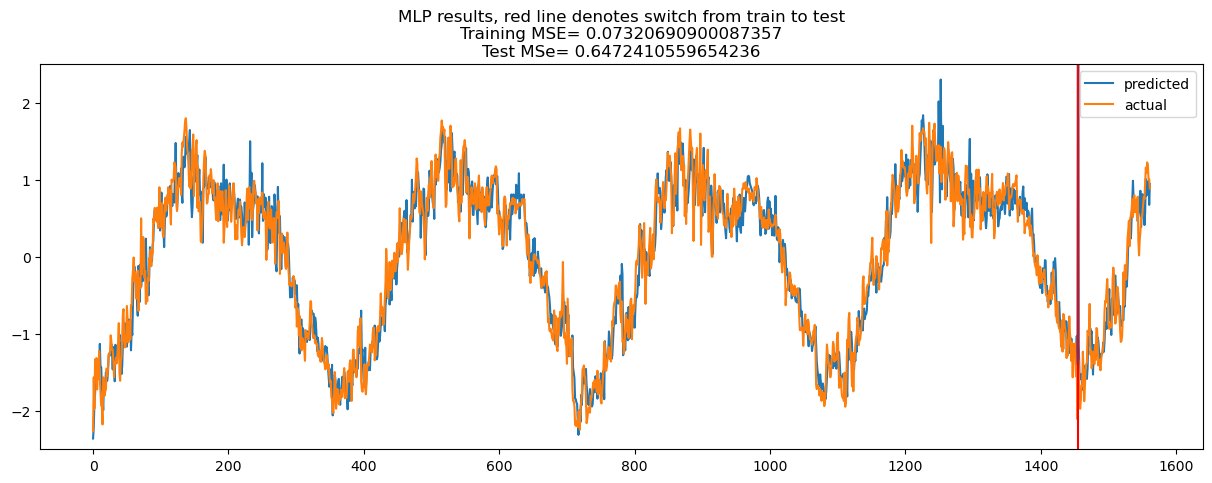

In [22]:
evaluate_and_report(mlp,"MLP", flattened_train32, flattened_test32)

# Algorithm 2: A 1-D CNN

## Preprocess the data
The 2D CNN neeed to know the height and width of images in order to optimise its inner loops
- look at my code from week 2 for an example
- or [Keras.layers.Conv2d api](https://keras.io/api/layers/convolution_layers/convolution2d/)

Similarly the 1D CNN layer needs to have a fixed size number of timesteps (sequences) to work with
- not necessarily the same as the size of the filters (usually bigger)
- but  it needs to know the size of the loop to run it's filters over


So we can re-use the code we wrote to create the datasets 
- we'll change  the length of sequences we convolve over to 20 so convolution has something to work with
- but we should consider the number of timesteps in a sequence as a hyper-paramter to optimise


In [28]:


cnn_train = train_series.batch(larger_batch_size,drop_remainder=True)

cnn_test = test_series.batch(larger_batch_size,drop_remainder=True)

In [32]:
batch_shape= list(cnn_test.take(1))[0][0].shape
print(f'shape of batches is {batch_shape}')

shape of batches is (32, 1, 7, 4)


## Now specify the 1D CNN architecture
- Let's see how we get on with kernel size 3 (days) : another hyper-parameter to be tuned
- we also need to specify the input shape which is (batch_size,1,sequence_length, num_features)  
  i.e the shape of the batches we just found

   

In [46]:
oneD_cnn = Keras.Sequential(
                           [ Keras.layers.Conv1D(
                                 filters=num_nodes,
                                 kernel_size=5,
                                 batch_input_shape=batch_shape,
                                 activation='relu'
                                 ),
                            Keras.layers.Flatten(),
                            Keras.layers.Dense(1,activation='linear')]
            )
oneD_cnn.compile(optimizer='adam', loss='mse')
oneD_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (1, 3, 32)                672       
                                                                 
 flatten_1 (Flatten)         (1, 96)                   0         
                                                                 
 dense_4 (Dense)             (1, 1)                    97        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [34]:
history= oneD_cnn.fit(cnn_train, epochs=epochs)

Epoch 1/15
23/45 [==============>...............] - ETA: 0s - loss: 0.5360

2023-03-15 11:54:00.927507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 0s 5ms/step - loss: 0.3650
Epoch 2/15
45/45 [==============================] - 0s 4ms/step - loss: 0.1316
Epoch 3/15
45/45 [==============================] - 0s 4ms/step - loss: 0.1086
Epoch 4/15
45/45 [==============================] - 0s 4ms/step - loss: 0.0965
Epoch 5/15
45/45 [==============================] - 0s 4ms/step - loss: 0.0880
Epoch 6/15
45/45 [==============================] - 0s 5ms/step - loss: 0.0816
Epoch 7/15
45/45 [==============================] - 0s 5ms/step - loss: 0.0765
Epoch 8/15
45/45 [==============================] - 0s 5ms/step - loss: 0.0723
Epoch 9/15
45/45 [==============================] - 0s 5ms/step - loss: 0.0689
Epoch 10/15
45/45 [==============================] - 0s 5ms/step - loss: 0.0660
Epoch 11/15
45/45 [==============================] - 0s 4ms/step - loss: 0.0636
Epoch 12/15
45/45 [==============================] - 0s 4ms/step - loss: 0.0615
Epoch 13/15
45/45 [==============================] - 0s 5ms/

3/3 [==============================] - 0s 4ms/step - loss: 0.1528


2023-03-15 11:54:06.800602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 2ms/step


2023-03-15 11:54:07.206429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


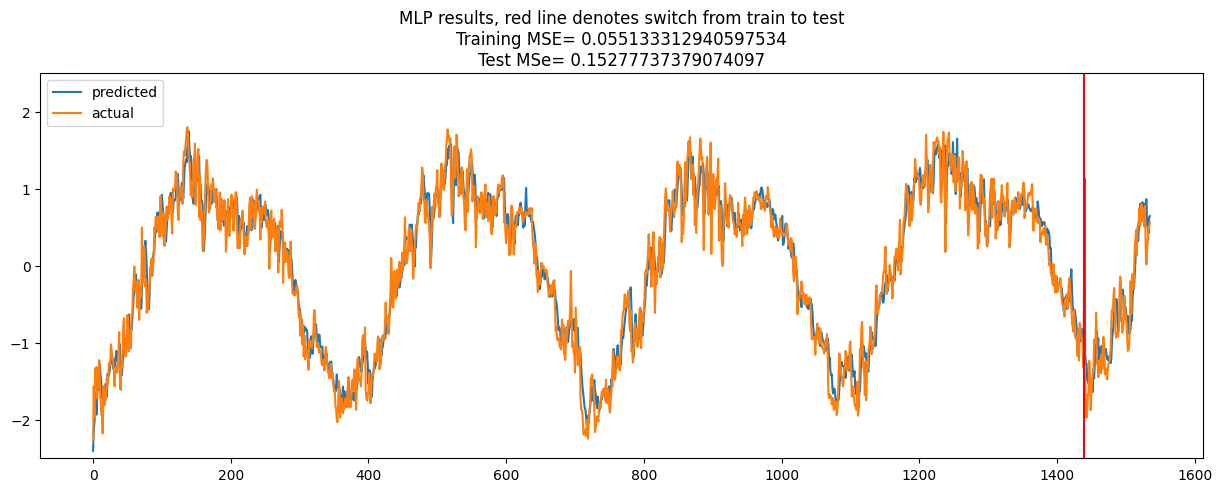

In [35]:
evaluate_and_report(oneD_cnn,"1-D ConvNet",cnn_train,cnn_test)

# Algorithm 3 LSTM Network
- For the LSTMs we will simply use our original dataset, 
- noting that we only have batchsize 1 which is slower, 
  but makes sense if we also preserve state between timesteps
- getting the sequence length right would be a good start for experimentation

### Warning: this is considerably (batch_size X) slower than MLP or CNN  

## Preprocess data

In [38]:
lstm_train=  train_series
lstm_test=  test_series

In [39]:
batch_shape = list(lstm_test.take(1))[0][0].shape
print(f' for the lstm the batch shape is {batch_shape}' )

 for the lstm the batch shape is (1, 7, 4)


## Define and train model

In [43]:
lstmnet=Keras.Sequential(
        [Keras.layers.LSTM(units=num_nodes,
                           stateful=True,
                           batch_input_shape=batch_shape),
         Keras.layers.Dense(1)]
)

lstmnet.compile(optimizer='adam',loss='mse')
history=lstmnet.fit(lstm_train,epochs=epochs)


Epoch 1/15


2023-03-15 11:55:54.921868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 11:55:54.990428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 11:55:55.096312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1455/1455 [==============================] - 12s 8ms/step - loss: 0.1318
Epoch 2/15
1455/1455 [==============================] - 11s 8ms/step - loss: 0.0793
Epoch 3/15
1455/1455 [==============================] - 11s 8ms/step - loss: 0.0654
Epoch 4/15
1455/1455 [==============================] - 11s 8ms/step - loss: 0.0573
Epoch 5/15
1455/1455 [==============================] - 11s 8ms/step - loss: 0.0530
Epoch 6/15
1455/1455 [==============================] - 11s 8ms/step - loss: 0.0508
Epoch 7/15
1455/1455 [==============================] - 11s 8ms/step - loss: 0.0497
Epoch 8/15
1455/1455 [==============================] - 11s 8ms/step - loss: 0.0488
Epoch 9/15
1455/1455 [==============================] - 11s 8ms/step - loss: 0.0482
Epoch 10/15
1455/1455 [==============================] - 11s 8ms/step - loss: 0.0477
Epoch 11/15
1455/1455 [==============================] - 11s 8ms/step - loss: 0.0472
Epoch 12/15
1455/1455 [==============================] - 11s 8ms/step - loss: 0.0466


## Evaluate and show results

  22/1455 [..............................] - ETA: 7s - loss: 0.0775 

2023-03-15 11:58:53.563244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 11:58:53.595736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  34/1455 [..............................] - ETA: 4s

2023-03-15 11:59:00.822035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 11:59:00.847261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 0s 3ms/step


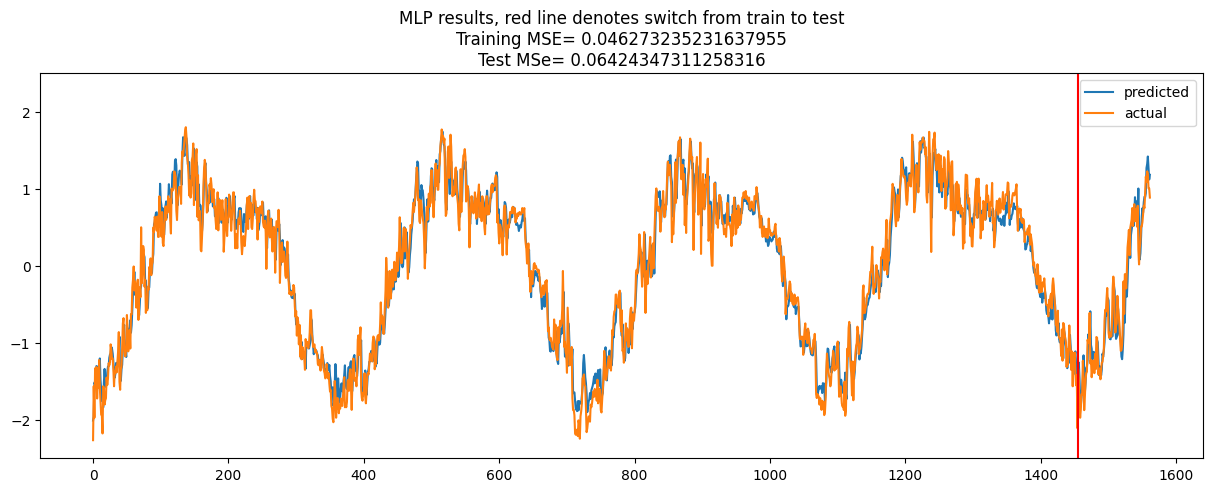

In [44]:
evaluate_and_report(lstmnet,"LSTM", lstm_train,lstm_test)
